In [8]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import wandb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import TensorDataset
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import torch.utils.data as Data
from torchvision import transforms
import scipy.io
import seaborn as sns
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

https://wandb.ai/smaia3/DRP0.5_Q4/reports/Question-4-Additional--Vmlldzo1NzU1Njk4?accessToken=2labds0k3e0qb00g0z88z5thhfngn5hqumehlvjcn4u1qur5250fikyyjxdti004

## after introducing DRP 
https://wandb.ai/smaia3/NORMAL_Q4/reports/Question-4--Vmlldzo1NzU1ODEz?accessToken=wvr9asmkeaa1pc79wwjyhg1f89lwgdegkwfc2z28rurvnu6jf7yd4eyp95izi77k

### Using Dropout Layers:

Reduces Overfitting: Dropout layers are effective in reducing overfitting. When dropout is applied, the model becomes less reliant on any individual neuron and, therefore, it learns a more robust and generalized representation of the data.

Increased Training Time: Dropout may slow down training time. During training, for each forward and backward pass, a fraction of neurons is randomly "dropped out." This requires more iterations to reach convergence compared to not using dropout.

Overfitting: Without dropout, there is a higher risk of overfitting, especially if the model architecture is complex and there is limited training data.

Higher Risk of Memorization: Without dropout, the network may memorize the training data rather than learning general patterns. This can lead to poor performance on unseen data.

Dependence on Data Augmentation: Data augmentation techniques (e.g., rotating, flipping, or cropping images) may be more critical when dropout is not used to ensure the model generalizes well.



tensor([1.], device='mps:0')
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


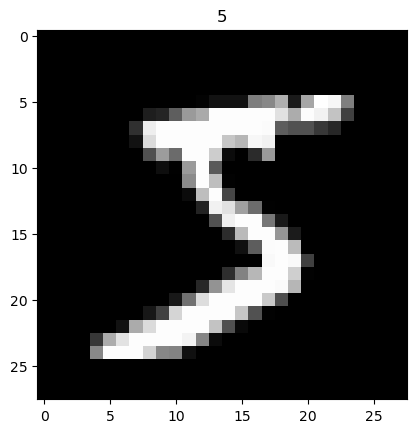

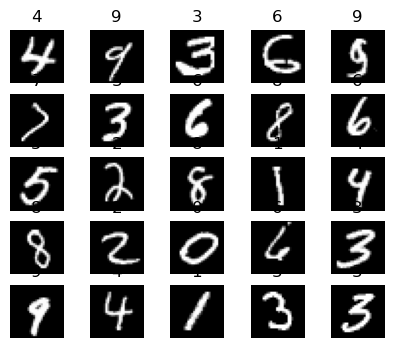

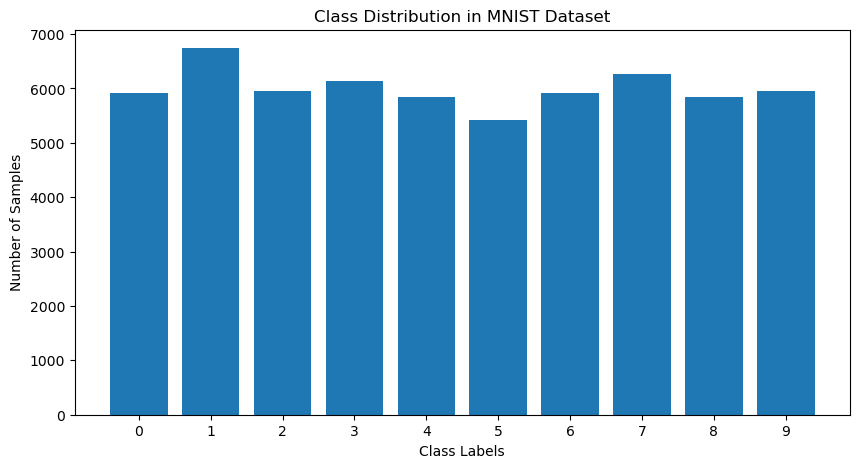

In [9]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

train_data = datasets.MNIST(root = 'data', train = True, transform = ToTensor(), download = True,)
test_data = datasets.MNIST(root = 'data', train = False, transform = ToTensor())
validation_data = datasets.MNIST(root = 'data', train = False, transform = ToTensor())

# 28 x 28

print(train_data)
print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()
figure = plt.figure(figsize=(5, 4))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


labels = train_data.targets.numpy()
label_counts = {}
for label in labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1
sorted_labels, counts = zip(*sorted(label_counts.items()))
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, counts)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in MNIST Dataset')
plt.xticks(range(10))  # Assuming there are 10 classes (0 to 9)
plt.show()

The provided code defines a CNN (Convolutional Neural Network) class and a training function for this network. The CNN class is designed with two convolutional layers, each followed by a ReLU activation function and max-pooling. It then has a fully connected layer that produces output with 10 classes. The training function, `train`, takes a CNN model, data loaders, an optimizer, and a loss function as inputs. It trains the model using the specified data loaders and optimizer for a given number of epochs. It also logs training and validation metrics like loss, accuracy, confusion matrix, and class-specific metrics. This code is structured for training a CNN model for classification tasks while keeping track of performance metrics during training. It utilizes PyTorch and Weights & Biases (wandb) for logging these metrics.

In [10]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, pool_ratio, dropout_rate):
        super(CNN, self).__init__()
        
        # Define your convolutional layers using the provided parameters
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(pool_ratio)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, 2 * out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(pool_ratio)
        )
        
        # Calculate the output shape for the fully connected layer
        conv_output_size = self.calculate_conv_output_size(in_channels)
        
        
        # Define the fully connected layer
        self.out = nn.Linear(conv_output_size, 10)          # softmax as linear 
        self.dropout = nn.Dropout(dropout_rate)

        # Define the activation to be used in the fully connected layer
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.pool_ratio = pool_ratio
    
    def calculate_conv_output_size(self, in_channels):
        # Assuming  28x28 images
        input_tensor = torch.randn(1, in_channels, 28, 28)
        conv_output = self.conv1(input_tensor)
        conv_output = self.conv2(conv_output)
        conv_output_size = conv_output.view(conv_output.size(0), -1).size(1)
        return conv_output_size
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Apply dropout to the fully connected layer
        # Apply softmax activation
        softmax_output = F.softmax(x, dim=1)
        self.outputs = softmax_output
        output = self.out(x)
        return output, x   

def train(num_epochs, cnn, loaders, optimizer, loss_func):
    cnn.train()
    # Train the model
    # total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            output = cnn(Variable(images))[0]               
            loss = loss_func(output, Variable(labels))
            # clear gradients for this training step   
            optimizer.zero_grad()           
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
                
        total_correct = 0
        total_samples = 0
        predicted_labels = []
        true_labels = []
        for i, (images, labels) in enumerate(loaders['train']):
            output = cnn(Variable(images))[0]
            loss = loss_func(output, Variable(labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)
            # Collect predicted and true labels for later
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

        accuracy = total_correct / total_samples
        # Calculate confusion matrix and class-specific metrics
        confusion = confusion_matrix(true_labels, predicted_labels)
        class_report = classification_report(true_labels, predicted_labels, zero_division=0)

        # wandb.log({"isVal": 0, "epoch": epoch*10, "loss": loss.item(), "accuracy": accuracy, "confusion_matrix": confusion, "class_report": class_report})

        # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        #         .format(epoch + 1, num_epochs, i + 1, len(loaders['train']), loss.item(),
        #                 (accuracy * 100)))
        # print(confusion)
        # print(class_report)


        # calculate loss and accuracy for validation set
        total_correct = 0
        total_samples = 0
        predicted_labels = []
        true_labels = []
        for i, (images, labels) in enumerate(loaders['validation']):
            output = cnn(Variable(images))[0]
            loss = loss_func(output, Variable(labels))
            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)
            # Collect predicted and true labels for later
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
        
        accuracy = total_correct / total_samples
        # Calculate confusion matrix and class-specific metrics
        confusion = confusion_matrix(true_labels, predicted_labels)
        class_report = classification_report(true_labels, predicted_labels, zero_division=0)
        # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        #         .format(epoch + 1, num_epochs, i + 1, len(loaders['train']), loss.item(),
        #                 (accuracy * 100)))
        # print(confusion)
        # print((class_report))
        
        # wandb.log({"isVal": 1, "epoch": epoch*10, "loss": loss.item(), "accuracy": accuracy, "confusion_matrix": confusion, "class_report": class_report})

In [11]:
# iterate over various values of kerner size, stride, padding, pool_ratio
kernels = [2, 4]
strides = [1, 2]
paddings = [1, 2]
learning_rates = [0.01, 0.1, 0.5]
pool_ratio = 2
num_epochs = 3
loss_func = nn.CrossEntropyLoss()   
batches = [50, 100]
drp = 0
for batch in batches:
    loaders = {
        'train'         : torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=1),
        'test'          : torch.utils.data.DataLoader(test_data , batch_size=batch, shuffle=True, num_workers=1),
        'validation'    : torch.utils.data.DataLoader(test_data , batch_size=batch, shuffle=True, num_workers=1),
    }
    for kernel_size in kernels:
        for stride in strides:
            for padding in paddings:
                for lr in learning_rates:
                    wandb.init(
                        # set the wandb project where this run will be logged
                        project="NORMAL_Q4",
                        # track hyperparameters and run metadata
                        config={
                            "learning_rate": lr,
                            "architecture": "Logistic Regression",
                            "dataset": "wineQT",
                        },
                        name=f"LR_{lr}KS_{kernel_size}ST_{stride}PA_{padding}BS_{batch}" 
                    )
                    wandb.config.learning_rate = lr
                    cnn = CNN(in_channels=1, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding, pool_ratio=pool_ratio, dropout_rate=drp)
                    optimizer = optim.Adam(cnn.parameters(), lr = lr)   
                    train(num_epochs, cnn, loaders, optimizer, loss_func)

drp = 0.5
for batch in batches:
    loaders = {
        'train'         : torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=1),
        'test'          : torch.utils.data.DataLoader(test_data , batch_size=batch, shuffle=True, num_workers=1),
        'validation'    : torch.utils.data.DataLoader(test_data , batch_size=batch, shuffle=True, num_workers=1),
    }
    for kernel_size in kernels:
        for stride in strides:
            for padding in paddings:
                for lr in learning_rates:
                    wandb.init(
                        # set the wandb project where this run will be logged
                        project="DRP0.5_Q4",
                        # track hyperparameters and run metadata
                        config={
                            "learning_rate": lr,
                            "architecture": "Logistic Regression",
                            "dataset": "wineQT",
                        },
                        name=f"LR_{lr}KS_{kernel_size}ST_{stride}PA_{padding}BS_{batch}" 
                    )
                    wandb.config.learning_rate = lr
                    cnn = CNN(in_channels=1, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding, pool_ratio=pool_ratio, dropout_rate=drp)
                    optimizer = optim.Adam(cnn.parameters(), lr = lr)   
                    train(num_epochs, cnn, loaders, optimizer, loss_func)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aryan-g (smaia3). Use `wandb login --relogin` to force relogin


Problem at: /Users/arygup/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_init.py 852 getcaller


KeyboardInterrupt: 

In [ ]:
def test(cnn, loaders):
    # Test the model
    cnn.eval()
    accuracy = 0
    sum = 0
    with torch.no_grad():
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy += float((pred_y == labels).sum().item() / float(labels.size(0)))
            sum += 1
    print('Test Accuracy of the model on the 10000 test images:', accuracy/sum)
    

loaders = {
    'train'         : torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True, num_workers=1),
    'test'          : torch.utils.data.DataLoader(test_data , batch_size=200, shuffle=True, num_workers=1),
    'validation'    : torch.utils.data.DataLoader(test_data , batch_size=200, shuffle=True, num_workers=1),
}

cnn4 = CNN(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=2, pool_ratio=2, dropout_rate=0)
optimizer = optim.Adam(cnn4.parameters(), lr = 0.01)   
loss_func = nn.CrossEntropyLoss()
train(2, cnn4, loaders, optimizer, loss_func)
test(cnn4, loaders)

Test Accuracy of the model on the 10000 test images: 0.9850999999999995


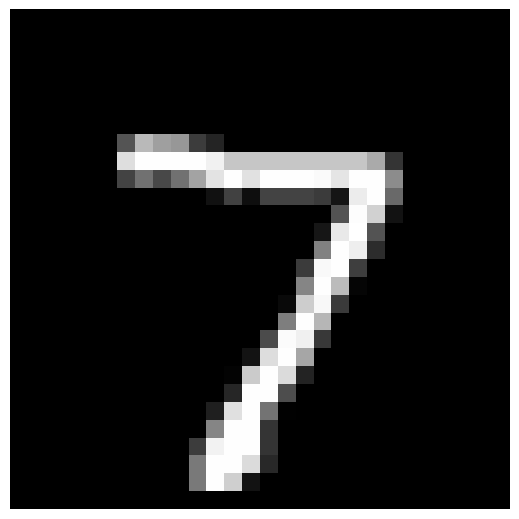

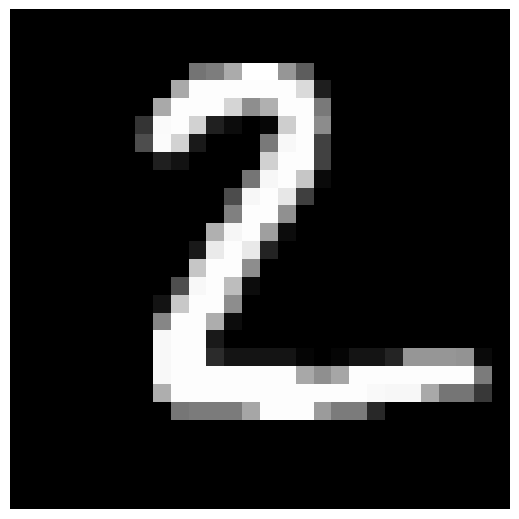

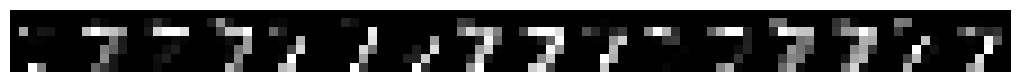

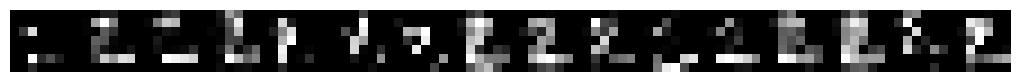

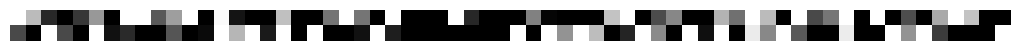

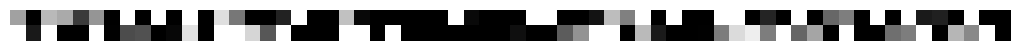

In [20]:
def visualise_feature_maps(layer_output):
    N , C , H , W = layer_output.shape
    for i in range(N):
        fig = plt.figure(figsize=(10 , 10))
        for j in range(C):
            ax = fig.add_subplot(N , C , i*C + j + 1)
            ax.imshow(layer_output[i][j].detach().numpy() , cmap='gray')
            ax.axis('off')
        plt.subplots_adjust(wspace=0 , hspace=0 , top = 1 , bottom = 0 , left = 0 , right = 1)
        plt.show()

test_loader = loaders['test']  

dat = test_loader.dataset.data[0:2].unsqueeze(1).float()
f1 = cnn4.conv1(dat)
f2 = cnn4.conv2(f1)

visualise_feature_maps(dat)
visualise_feature_maps(f1)
visualise_feature_maps(f2)


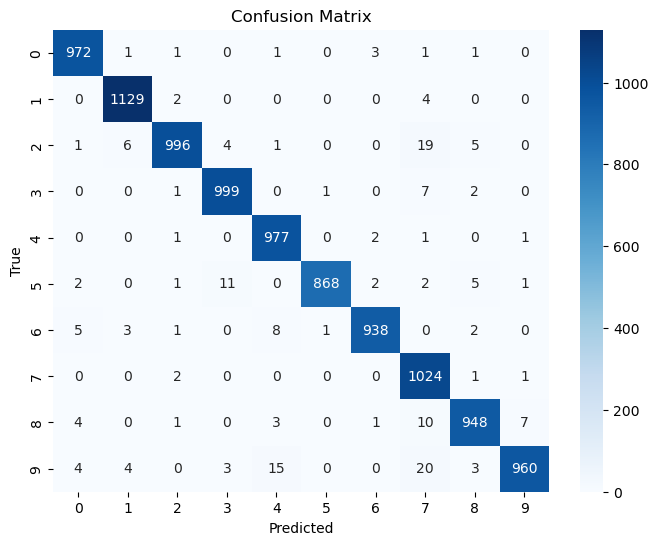

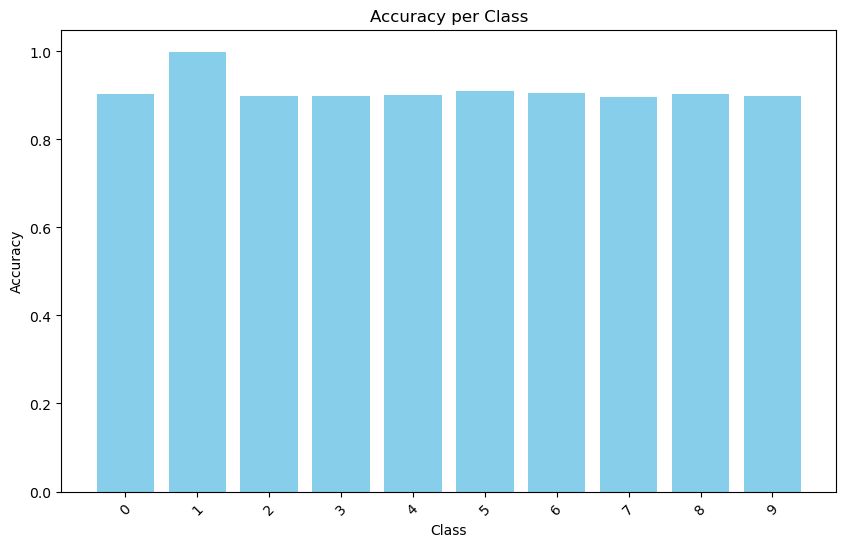

Test Accuracy: 0.9811
Per-Class Accuracy: [0.9021, 0.9994, 0.8974, 0.899, 0.9018, 0.9108, 0.9045, 0.8972, 0.9026, 0.8995]
Classification Report:
 {'0': {'precision': 0.9838056680161943, 'recall': 0.9918367346938776, 'f1-score': 0.9878048780487805, 'support': 980.0}, '1': {'precision': 0.9877515310586177, 'recall': 0.9947136563876652, 'f1-score': 0.9912203687445127, 'support': 1135.0}, '2': {'precision': 0.9900596421471173, 'recall': 0.9651162790697675, 'f1-score': 0.9774288518155055, 'support': 1032.0}, '3': {'precision': 0.9823008849557522, 'recall': 0.9891089108910891, 'f1-score': 0.9856931425752343, 'support': 1010.0}, '4': {'precision': 0.972139303482587, 'recall': 0.994908350305499, 'f1-score': 0.9833920483140413, 'support': 982.0}, '5': {'precision': 0.9977011494252873, 'recall': 0.9730941704035875, 'f1-score': 0.9852440408626562, 'support': 892.0}, '6': {'precision': 0.9915433403805497, 'recall': 0.9791231732776617, 'f1-score': 0.9852941176470588, 'support': 958.0}, '7': {'preci

In [ ]:
def evaluate_model(cnn, test_loader):
    cnn.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            test_output, _ = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            all_predictions.extend(pred_y.tolist())
            all_labels.extend(labels.tolist())
    accuracy = accuracy_score(all_labels, all_predictions)
    class_accuracy = []
    for class_idx in range(10):  
        mask = [1 if label == class_idx else 0 for label in all_labels]
        class_accuracy.append(accuracy_score(mask, [p if l == class_idx else 0 for p, l in zip(all_predictions, all_labels)]))
    report = classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)], output_dict=True)
    confusion = confusion_matrix(all_labels, all_predictions)
    return accuracy, class_accuracy, report, confusion
test_loader = loaders['test']  
accuracy, class_accuracy, report, confusion = evaluate_model(cnn4, test_loader)

plt.figure(figsize=(8, 6))
class_names = [str(i) for i in range(10)]  
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_names = [str(i) for i in range(len(class_accuracy))]  
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracy, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.xticks(rotation=45)
plt.show()

print("Test Accuracy:", accuracy)
print("Per-Class Accuracy:", class_accuracy)
print("Classification Report:\n", report)

In [ ]:
imgs, lbls = next(iter(loaders['test']))
actual_number = lbls[:10].numpy()
test_output, last_layer = cnn4(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number:     {actual_number}')

Prediction number: [3 3 3 9 2 8 1 4 7 0]
Actual number:     [3 3 3 9 2 8 1 4 7 0]


Misclassified Samples


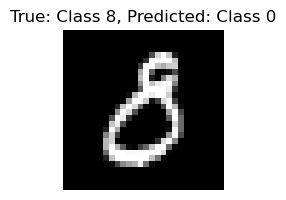

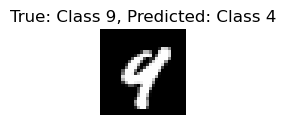

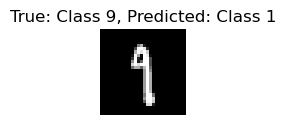

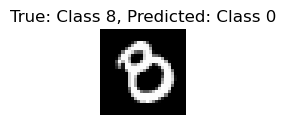

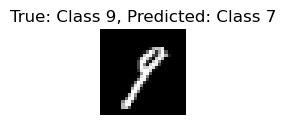

In [ ]:
def analyze_misclassifications(model, test_loader, class_labels):
    misclassified_samples = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs, _ = model(images)
            predicted_labels = torch.argmax(outputs, dim=1)
            misclassified_indices = (predicted_labels != labels).nonzero()
            for idx in misclassified_indices:
                image = images[idx].squeeze().cpu().numpy()
                true_label = labels[idx].item()
                predicted_label = predicted_labels[idx].item()
                misclassified_samples.append({
                    'image': image,
                    'true_label': true_label,
                    'predicted_label': predicted_label
                })
    return misclassified_samples

def plot_misclassifications(misclassified_samples, class_labels):
    num_misclassifications = len(misclassified_samples)
    num_samples_to_display = min(5, num_misclassifications)
    plt.figure(figsize=(12, 6))
    print('Misclassified Samples')
    for i in range(num_samples_to_display):
        sample = misclassified_samples[i]
        plt.subplot(1, num_samples_to_display, i + 1)
        plt.imshow(sample['image'], cmap='gray')
        plt.title(f'True: {class_labels[sample["true_label"]]}, Predicted: {class_labels[sample["predicted_label"]]}')
        plt.axis('off')
        plt.show()

class_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7", "Class 8", "Class 9"]
misclassified_samples = analyze_misclassifications(cnn4, loaders['test'], class_labels)
plot_misclassifications(misclassified_samples, class_labels)

When visually analyzing the misclassified samples, it is observed that these images often exhibit ambiguity or flaws in the handwriting. 5 & 3, 2 & 7, 8 & 3 anwyays have very similar visual structures therefore the misclassified samples appear to have characteristics that could be interpreted as multiple possible labels, and these ambiguities make it challenging even for a human observer to determine the correct label. This visual examination aligns with the model's misclassifications, as it struggles with the same ambiguities and uncertainties in the input data, resulting in incorrect predictions. In summary, the misclassified images indeed have features that make it difficult to assign a single, unambiguous label, and the model's errors are often understandable in a visual context.

# AutoEncoders

In [21]:
data = scipy.io.loadmat('mnist-with-awgn.mat')
for x in data.keys():
    print(x)

__header__
__version__
__globals__
train_x
test_x
train_y
test_y


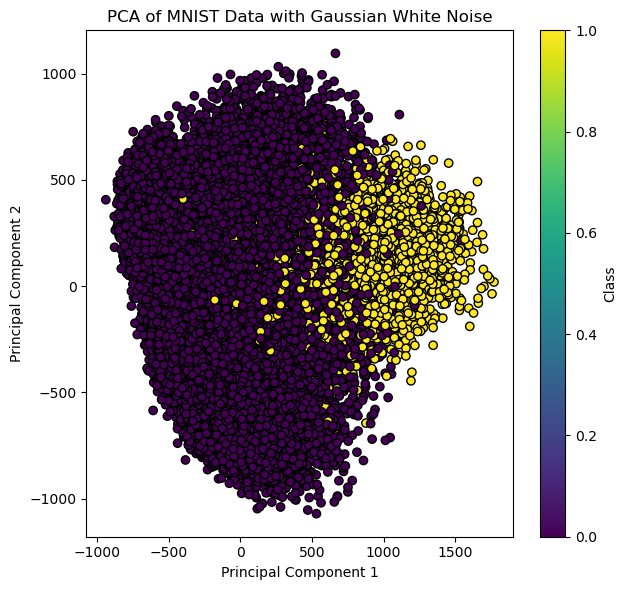

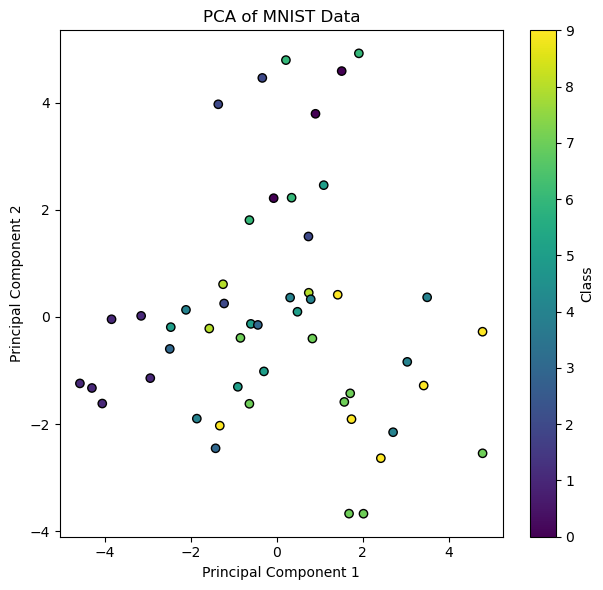

In [ ]:
pca = PCA(n_components=2)
xxx = data['train_x']
noisy_train_data_pca = pca.fit_transform(xxx)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(noisy_train_data_pca[:, 0], noisy_train_data_pca[:, 1], c=data['train_y'][:, 0], cmap='viridis', marker='o', edgecolors='k')
plt.title("PCA of MNIST Data with Gaussian White Noise")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class")
plt.tight_layout()
plt.show()

loaders = {'train' : torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers=1),}
train_data_iterator = iter(loaders['train'])
data, labels = next(train_data_iterator)  
data = data.view(data.size(0), -1).numpy()
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
# plot the data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolors='k')
plt.title("PCA of MNIST Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class")
plt.tight_layout()
data = scipy.io.loadmat('mnist-with-awgn.mat')

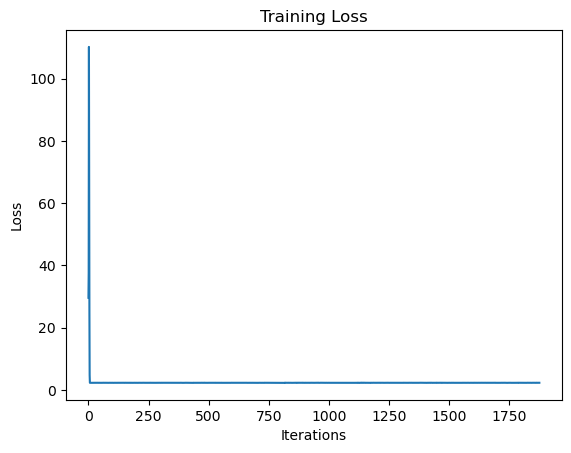

Final Training Loss: 2.3081116676330566
Final Training Accuracy: 0.1135

Final Test Accuracy: 0.11236666666666667
Hamming Loss: 0.8987261146496816
Precision: 0.9936305732484076
Recall: 0.09959306440198158
F1 Score: 0.181033262561925

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.99      1.00      1.00       156
           2       0.00      0.00      0.00       157
           3       0.00      0.00      0.00       157
           4       0.00      0.00      0.00       156
           5       0.00      0.00      0.00       157
           6       0.00      0.00      0.00       157
           7       0.00      0.00      0.00       156
           8       0.00      0.00      0.00       156
           9       0.00      0.00      0.00       157

   micro avg       0.99      0.10      0.18      1566
   macro avg       0.10      0.10      0.10      1566
weighted avg       0.10      0.10      0.10      1566
 samples

In [22]:
# Define hyperparameters
batch_size = 64
learning_rate = 0.01
training_losses = []
num_epochs = 2
training_accuracies = []

noisy_train_data = data['train_x']
noisy_train_labels = data['train_y']
noisy_test_data = data['test_x']
noisy_test_labels = data['test_y']

train_dataset = TensorDataset(torch.Tensor(noisy_train_data), torch.LongTensor(noisy_train_labels))
test_dataset = TensorDataset(torch.Tensor(noisy_test_data), torch.LongTensor(noisy_test_labels))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loss_func = nn.CrossEntropyLoss()
cnn2 = CNN(1, 16, 3, 1, 1, 2, 0)
optimizer = optim.Adam(cnn2.parameters(), lr=learning_rate)
cnn2.train()

# train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 1, 28, 28)
        output = cnn2(Variable(images))[0]
        labels = labels.float()
        loss = loss_func(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())

# plot the training loss
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# test on the test set
cnn2.eval()
correct = 0
total = 0
correct1 = 0
total1 = 0
true_labelss = []
preds_y = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 1, 28, 28)
        test_output, last_layer = cnn2(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        true_labels = torch.max(labels, 1)[1].data
        total += true_labels.size(0)
        correct += float((pred_y == true_labels).sum().item())
        preds_y.append(pred_y.tolist())
        true_labelss.append(true_labels.tolist())

    for images, labels in train_loader:
        images = images.view(-1, 1, 28, 28)
        test_output, last_layer = cnn2(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        true_labels = torch.max(labels, 1)[1].data
        total1 += true_labels.size(0)
        correct1 += float((pred_y == true_labels).sum().item())

accuracy = correct / total

print("Final Training Loss:", training_losses[-1])
print("Final Training Accuracy:", accuracy)

print()
mlb = MultiLabelBinarizer()
true_labels_binary = mlb.fit_transform(true_labelss)
preds_binary = mlb.transform(preds_y)

hamming_loss_value = hamming_loss(true_labels_binary, preds_binary)
f1 = f1_score(true_labels_binary, preds_binary, average='samples')
precision = precision_score(true_labels_binary, preds_binary, average='samples')
recall = recall_score(true_labels_binary, preds_binary, average='samples')
print("Final Test Accuracy:", correct1 / total1)
print("Hamming Loss:", hamming_loss_value)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print()
print(classification_report(true_labels_binary, preds_binary, zero_division=0))

The Autoencoder consists of two main components: an encoder and a decoder. The encoder part takes an input, flattens it, and passes it through a series of fully connected layers with ReLU activation functions, reducing the dimensionality of the data to create a compressed representation. The decoder then takes this compressed representation and uses fully connected layers with ReLU activation functions to reconstruct the original input data. The final output is a ReLU-activated layer. During the forward pass, an input is first encoded and then decoded, with the aim of reconstructing the input as accurately as possible. This process helps in learning meaningful representations from the data, and the model can be used for various tasks, including data denoising.

In [30]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder does the job of converting the input image into a compressed representation
        # compressed representation can be thought of as a latent vector
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),  # Flatten input images (28x28)
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        # Decoder does the job of converting the compressed representation back to the original image
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),  
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

When you compare the original images with their denoised counterparts, we can observe that the Gaussian white noise has been removed effectively. The denoised images appear clearer and closer to the original ones. The noise removal process is achieved through the Autoencoder, which has learned to encode and decode the images, filtering out the noise during reconstruction.

While removing noise helps clean up the images, the Autoencoder introduces a form of information loss due to its dimensionality reduction process. The encoder compresses the images into a lower-dimensional representation, and this compression might cause some loss of details.

To improve accuracy, we can consider Hyperparameter Tuning: Adjust the architecture and hyperparameters of the Autoencoder. This includes changing the number of layers and units in the encoder and decoder, as well as the activation functions. Experiment with different combinations to find a configuration that minimizes information loss.

It's a delicate balance between denoising and retaining essential image features.

### Clearly the accuracry and other metrics have increased by a huge factor

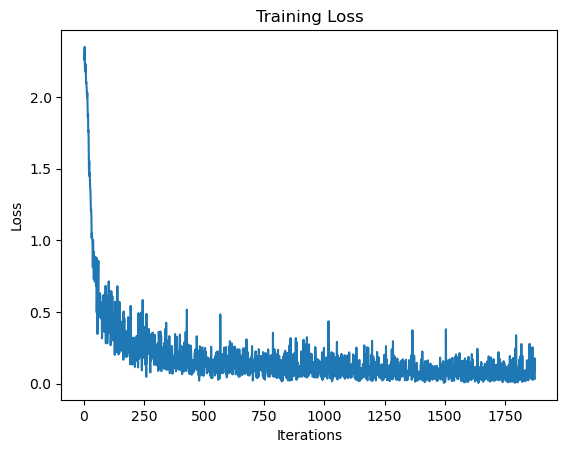

Test Accuracy of the model on the denoised test images: 0.9723
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.99      0.94      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



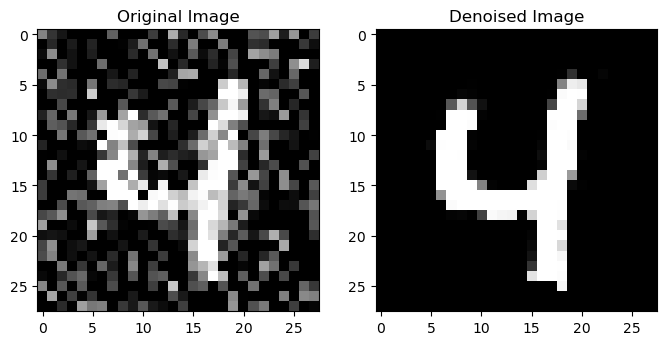

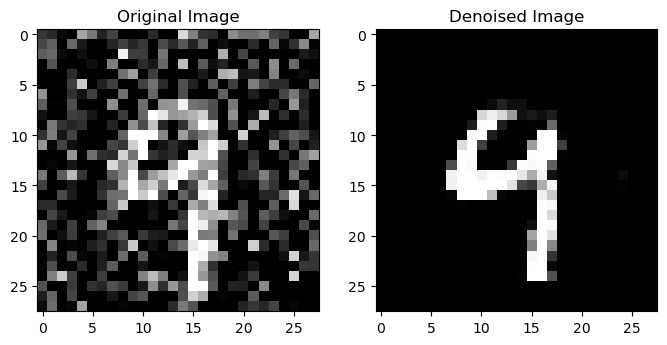

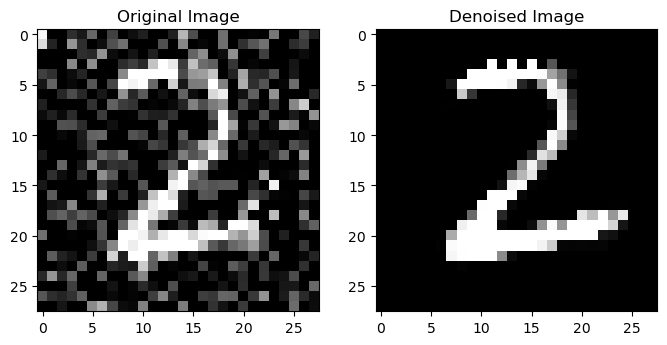

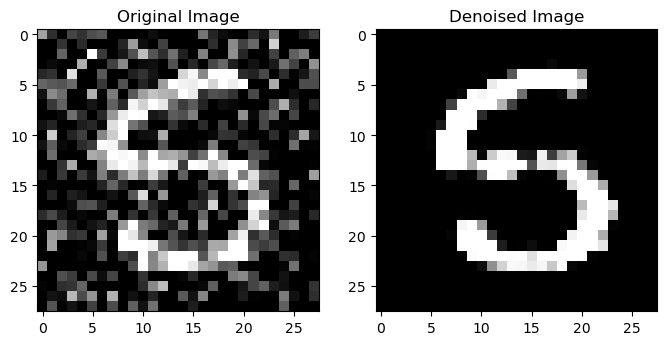

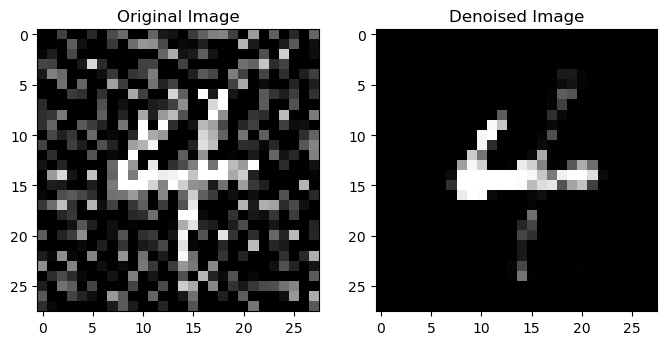

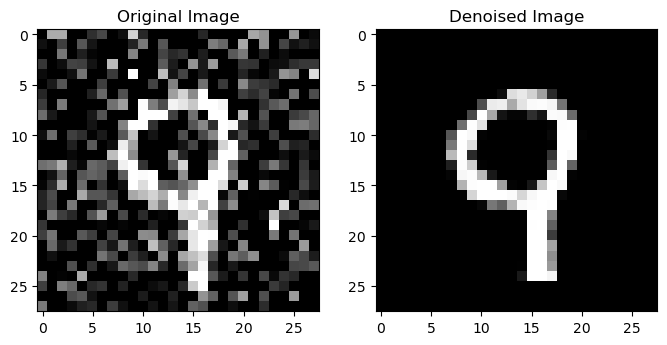

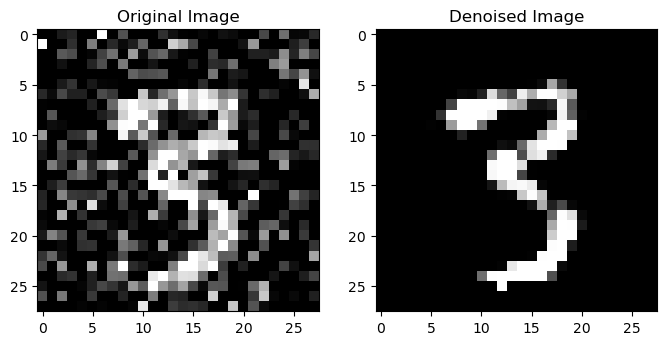

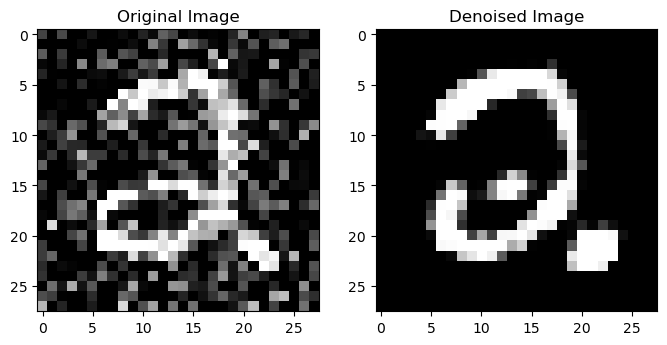

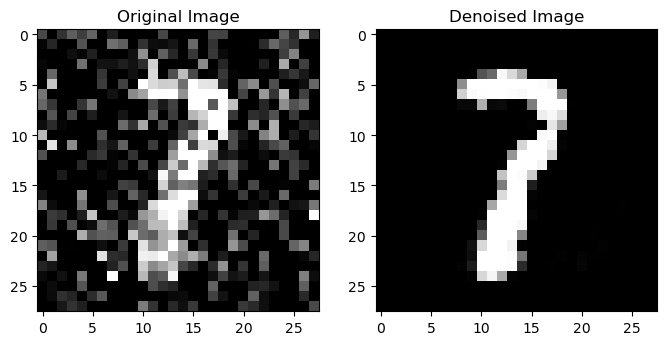

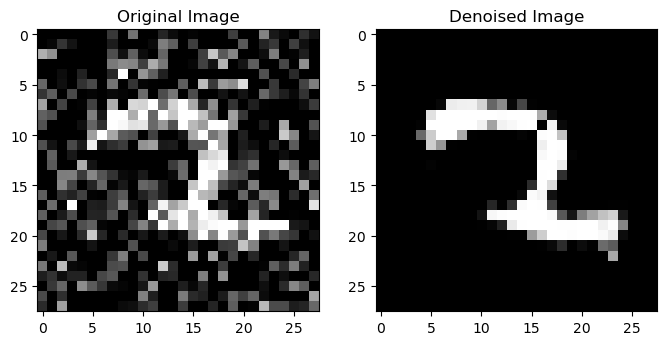

In [31]:
data = loadmat('mnist-with-awgn.mat')
noisy_train_data = data['train_x']
noisy_train_labels = data['train_y']
noise_test_data = data['test_x']
noisy_test_labels = data['test_y']

# Preprocess and normalize noisy data
scaler = StandardScaler()
noisy_train_data = scaler.fit_transform(noisy_train_data)
noisy_test_data = scaler.transform(noise_test_data)

# Create DataLoader for noisy data
batch_size = 64
train_dataset = Data.TensorDataset(torch.FloatTensor(noisy_train_data), torch.LongTensor(noisy_train_labels))
train_loader = Data.DataLoader(train_dataset, batch_size=batch_size)
test_dataset = Data.TensorDataset(torch.FloatTensor(noisy_test_data), torch.LongTensor(noisy_test_labels))
test_loader = Data.DataLoader(test_dataset, batch_size=batch_size)

autoencoder = Autoencoder()
criterion = nn.MSELoss()  # best for gaussian noise
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop for the autoencoder
for j in range(2):
    for data in train_loader:
        inputs, _ = data
        autoencoder_optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        autoencoder_optimizer.step()


# Denoise the dataset
denoised_data = []
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = autoencoder(inputs)
        denoised_data.append(outputs)


# Initialize CNN model 
training_losses = []
cnn3 = CNN(1, 16, 3, 1, 1, 2, 0)
cnn_optimizer = optim.Adam(cnn3.parameters(), lr=0.001)                 # best for gaussian white 
loss_func = nn.CrossEntropyLoss()
# Train your CNN on the denoised data
for j in range(2):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 1, 28, 28)
        output = cnn3(Variable(images))[0]
        labels = labels.float()
        loss = loss_func(output, labels)
        cnn_optimizer.zero_grad()
        loss.backward()
        cnn_optimizer.step()
        training_losses.append(loss.item())

# plot the training loss
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

denoised_test_data = []
# Denoise the test dataset
with torch.no_grad():
    for data in test_loader:  
        inputs, labels = data
        outputs = autoencoder(inputs)
        denoised_test_data.append(outputs)

# Iterate over the denoised test dataset
cnn3.eval()
accuracy = 0
total = 0
predicted_labels = []
true_labelss = []

with torch.no_grad():
    for images, labels in test_loader:  
        images = images.view(-1, 1, 28, 28)
        test_output, last_layer = cnn3(Variable(images))
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        # Extract class indices from the labels tensor
        true_labels = torch.max(labels, 1)[1].data
        accuracy += float((pred_y == true_labels).sum().item())
        total += true_labels.size(0)
        predicted_labels.extend(pred_y.tolist())
        true_labelss.extend(true_labels.tolist())
        
print('Test Accuracy of the model on the denoised test images:', accuracy / total)

# Calculate and print classification report
print(classification_report(true_labelss, predicted_labels, zero_division=0))

# Visualize the data before and after denoising
for i in range(10, 20):
    original_image = noise_test_data[i].reshape(28, 28)  # Reshape to (28, 28)
    denoised_image = denoised_test_data[0][i].reshape(28, 28)  # Reshape to (28, 28)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image, cmap='gray')
    plt.title('Denoised Image')
    plt.show()
